# Imports

In [74]:
import sys
import json
import os
import nltk
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
from nltk.tokenize import sent_tokenize

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *

# Data Loading & Preparation

For tidyQA, there are indexes provided for the possible answer passage holding the answer. If it is "-1" it does  NOT mean that the answer is in the last passage chunk but simply that there is no passage holding the answer for that question.

## MusiQue

In [ ]:
# data = []
# with open('../data/musique.jsonl', 'r') as f: 
#     for line in f: 
#         data.append(json.loads(line))

# len(data) # 19938
# answerable_data = []
# for i in range(len(data)) : 
#     if data[i]['answerable'] == True: 
#         answerable_data.append(data[i])

# filtered_data = {"question" : [], "context" : [], "answer" : []}
# answerable_data[0]['question'] # question
# answerable_data[0]['answer']
# context = [elem['paragraph_text'] for elem in answerable_data[0]['paragraphs']]


# for i in range(len(answerable_data)): 
#     filtered_data['question'].append(answerable_data[i]['question'])
#     filtered_data['answer'].append(answerable_data[i]['answer'])
#     context = [elem['paragraph_text'] for elem in answerable_data[i]['paragraphs']]
#     filtered_data['context'].append(context)

# df = pd.DataFrame.from_dict(filtered_data)



In [141]:
df = pd.read_json("../data/musique.jsonl", lines=True)
def get_titles(lst):
    # Titles where is_supporting is True
    supporting = [d['paragraph_text'] for d in lst if d.get('is_supporting') == True]
    # Titles where is_supporting is False or missing AND not already in supporting
    others = [d['paragraph_text'] for d in lst if d.get('is_supporting') != True and d['paragraph_text'] not in supporting]
    # Combine: all supporting + as many others as needed to reach 10
    result = supporting + others
    return result[:10]

df.paragraphs=df.paragraphs.apply(get_titles)
df.drop(['id', 'question_decomposition', 'answer_aliases', 'answerable'], axis = 1, inplace=True)


In [149]:
df.paragraphs = df.rename(columns = {'paragraphs' : 'context'}).context.apply(lambda x: [sent_tokenize(elem) for elem in x])

TypeError: Series.rename() got an unexpected keyword argument 'columns'

## TidyQA

###  Long Version Dataset

In [100]:
data = []
with open('../data/tydi.jsonl', 'r') as f: 
    for line in f: 
        data.append(json.loads(line))

In [101]:
english_data = []
for i in range(len(data)): 
    if data[i]['language'] == 'english': 
        english_data.append(data[i])

In [ ]:
english_data[0]['question_text'] # question
english_data[0]['document_plaintext'] # context
english_data[0]['document_title'] # title
# english_data[2]


'Zebra finch'

In [110]:
filtered_data = {'title' : [], 'context' : [],
                 'question' : []}
for i in range(len(english_data)) :
    filtered_data['title'].append(english_data[i]['document_title'])
    filtered_data['context'].append(english_data[i]['document_plaintext'])
    filtered_data['question'].append(english_data[i]['question_text'])

df = pd.DataFrame.from_dict(filtered_data)

### Short Version Dataset

In [48]:
f = open('../data/tydiqa.json', 'r')
data = json.load(f)

In [49]:
data['data'][0]['title'] # get title
data['data'][0]['paragraphs'][0]['context'] # get context
data['data'][0]['paragraphs'][0]['qas'][0]['question'] # get question
data['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]["text"]# get answer

'Wound care'

In [50]:
filtered_data = {"title" : [], "context" : [],
                 "question": [], "answer" : []}
for i in range(len(data['data'])) : 
    filtered_data['title'].append(data['data'][i]['title'])
    filtered_data['context'].append(data['data'][i]['paragraphs'][0]['context'])
    filtered_data['question'].append(data['data'][i]['paragraphs'][0]['qas'][0]['question'])
    filtered_data['answer'].append(data['data'][i]['paragraphs'][0]['qas'][0]['answers'][0]["text"])

df = pd.DataFrame.from_dict(filtered_data)

In [51]:
df.head()

,title,context,question,answer
0,Wound healing,Wound care encourages and speeds wound healing...,What is a way to increase your wound healing s...,Wound care
1,Burntisland Shipbuilding Company,Brothers Amos and Wilfrid Ayre founded Burntis...,Who founded the Burntisland Shipbuilding Company?,Amos and Wilfrid Ayre
2,Cerebral cortex,The cerebral cortex is folded in a way that al...,What is the surface area of the human cortex?,1.3 square feet
3,Agatha Christie,Guinness World Records lists Christie as the b...,How many units has Agatha Christie sold?,2 billion copies
4,Nájera,The town was conquered by Ordoño II of Leon fo...,When was Nájera established?,923


## Sentence Level

In [ ]:
flattened_list = [item for sublist in [sent_tokenize(elem) for elem in df['context'].loc[0]] for item in sublist]

In [64]:
if type(df.context.loc[0]) == list: 
    for i in range(len(df)) :
        df.loc[i, 'context'] = [item for sublist in[sent_tokenize(elem) for elem in df.loc[i, 'context']] for item in sublist]
else : 
    df['context'] = df.context.apply(lambda x: sent_tokenize(x))


In [65]:
df['context_size'] = df.context.apply(lambda x: len(x))

,question,context,answer,context_size


In [71]:
df = df[df.context_size >= 10].drop('context_size', axis = 1).copy()

In [73]:
df.to_csv('../data/prepared_musique.csv', index = False)

# Running Experiment

## Setup

In [128]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Main Script: Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [133]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
all_metrics_data = []
all_results=[]
M=[]
Fs=[]
pairs=[]
mse_inters=[]
mse_lins=[]
mse_fms=[]
dataset_name = 'tidyQA'

for i in tqdm(range(num_questions_to_run), desc="Processing Questions", disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    if isinstance(df.context[i], list) == False: 
        docs=ast.literal_eval(df.context[i])
    else: 
        docs = df.context[i]

    utility_cache_base_dir = f"../Experiment_data/{dataset_name}"
    utility_cache_filename = f"utilities_q_idx{i}_n{len(docs)}.pkl" # More robust naming
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)
    
    if accelerator_main.is_main_process: # Only main process creates directories
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)
        print(f"  Instantiating ShapleyExperimentHarness for Q{i} (n={len(docs)} docs)...")
    
    # Initialize Harness
    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model_for_harness=prepared_model,
        tokenizer_for_harness=tokenizer,
        accelerator_for_harness=accelerator_main,
        verbose=False
    )
    # Compute metrics
    results_for_query = {}
    # M.append(harness.compute_shapley_interaction_index_pairs_matrix())
    if accelerator_main.is_main_process:

        m_samples_map = {"L": 32}
        T_iterations_map = { "L":20}

        for size_key, num_s in m_samples_map.items():
            if 2**len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2**len(docs)-1 if 2**len(docs)>0 else 1)
            else:
                actual_samples = num_s
            
            print("HERE", actual_samples)

            if actual_samples > 0: 
                results_for_query[f"ContextCite{actual_samples}"] = harness.compute_contextcite(num_samples=actual_samples, seed=SEED)
                print("HERE")

                # results_for_query[f"WSS_FM{actual_samples}"], F, mse_fm = harness.compute_wss(num_samples=actual_samples, seed=SEED)
                # Fs.append(F)
                # mse_fms.append(mse_fm)
                results_for_query[f"BetaShap{actual_samples}"] = harness.compute_beta_shap(num_iterations_max=T_iterations_map[size_key], beta_a=4, beta_b=4, max_unique_lookups=actual_samples, seed=SEED)
                results_for_query[f"TMC{actual_samples}"] = harness.compute_tmc_shap(num_iterations_max=T_iterations_map[size_key], performance_tolerance=0.001, max_unique_lookups=actual_samples, seed=SEED)

        results_for_query["LOO"] = harness.compute_loo()
        results_for_query["ARC-JSD"] = harness.compute_arc_jsd()

        # exact_scores = results_for_query.get("ExactInter")
        all_results.append(results_for_query)

Processing Questions:   0%|          | 0/3 [00:00<?, ?it/s]


--- Question 1/3: Do zebra finches have stripes?... ---
  Instantiating ShapleyExperimentHarness for Q0 (n=205 docs)...


c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


HERE 32
HERE


  0%|          | 0/205 [00:00<?, ?it/s]


--- Question 2/3: Does Catholicism have any dietary restrictions?... ---
  Instantiating ShapleyExperimentHarness for Q1 (n=18 docs)...


c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


HERE 32
HERE


  0%|          | 0/18 [00:00<?, ?it/s]


--- Question 3/3: What is a way to increase your wound healing speed?... ---
  Instantiating ShapleyExperimentHarness for Q2 (n=349 docs)...


c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\Kalai\anaconda3\envs\llms\Lib\site-packages\transformers\generation\configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


HERE 32
HERE


  0%|          | 0/349 [00:00<?, ?it/s]

In [139]:
np.save('../Experiment_data/tidyQA/all_results.npy', all_results)

# Results Analysis

In [100]:
results = np.load('../Experiment_data/musiqueQA/all_results.npy', allow_pickle=True)
df = pd.read_csv('../data/musiqueQA.csv')

In [126]:
i = 2
print("Expected Answer: ", df['answer'].loc[i], "Provided Answer: ", results[i]['LLM_response'])

Expected Answer:  1999 Provided Answer:  1999


## Visualisation

In [94]:
import matplotlib.pyplot as plt
import numpy as np

In [130]:
df.context[1]

'[\'"The Spy in Black" was filmed at Denham Studios, with location shooting at Northchurch Common in Berkhamsted, Hertfordshire and in Orkney, Scotland.\', \'The film wrapped production on 24 December 1938 and was released in the U.K. on 12 August 1939 – 22 days before the country again went to war with Germany.\', \'Its American premiere was held in New York City on 5 October of that year, and it went into general release two days later.\', \'Thomas Fanshawe, 2nd Viscount Fanshawe (1632–1674) of Ware Park, Hertfordshire was an Irish peer and Member of Parliament.\', \'He was born to Thomas Fanshawe, 1st Viscount Fanshawe by his second wife Elizabeth Cockayne, the daughter of Sir William Cockayne, who served as the Lord Mayor of London in 1619.\', \'Birth control practices were generally adopted earlier in Europe than in the United States.\', "Knowlton\'s book was reprinted in 1877 in England by Charles Bradlaugh and Annie Besant, with the goal of challenging Britain\'s obscenity laws.

In [128]:
data = results[i]
input_data = df.loc[i]

In [129]:
input_data['question']

'When was the abolishment of the studio that distributed The Game?'

In [120]:
eval(input_data.context.replace('array', ''))[3]

'Thomas Fanshawe, 2nd Viscount Fanshawe (1632–1674) of Ware Park, Hertfordshire was an Irish peer and Member of Parliament.'

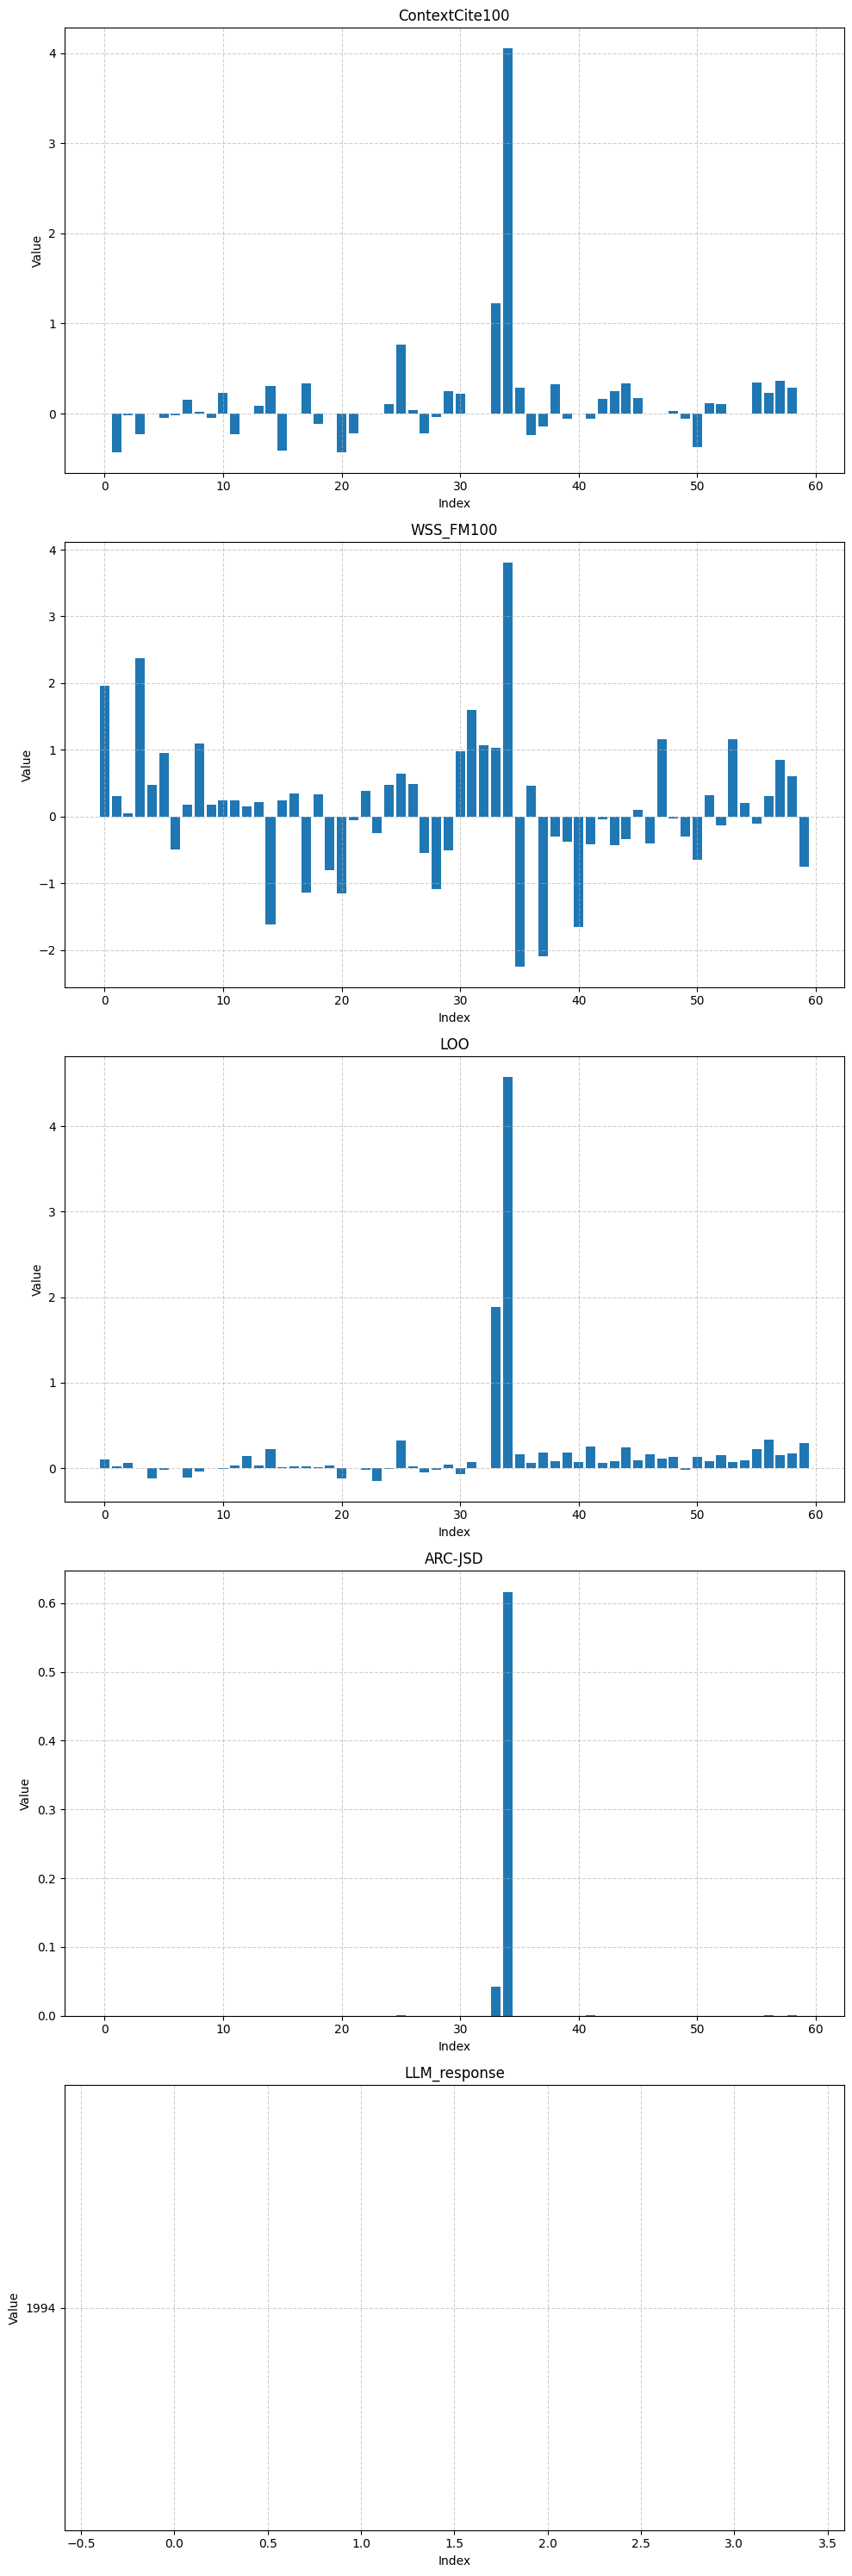

In [107]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=len(data), ncols=1, figsize=(10, 6*len(data)))
if len(data) == 1:
    axes = [axes]

# Create a bar plot for each key in the dictionary
for ax, (key, values) in zip(axes, data.items()):
    x = range(len(values))  # Create x-axis values
    ax.bar(x, values)
    ax.set_title(key)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()